# Solomon Experiment

This project implements a simulation of Solomon's four-group experimental design to evaluate the effects of a treatment and pretest. The code generates synthetic data for four distinct groups, applies statistical analysis using ANOVA, and visualizes the results. The goal is to demonstrate how different experimental setups influence post-test outcomes and to assess the impact of the pretest and treatment. This analysis is vital for understanding and isolating treatment effects in experimental research.

### Author: *Matteo Ciccarese*

**Library:**

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

To begin, let's set the stage for the experimental simulation:

- We ensure reproducibility with np.random.seed(42) to allow for consistent random data generation.
- We specify the group size and effects such as the number of participants per group (group_size), the treatment effect (treatment_effect), and the pretest effect (pretest_effect).
- We define the variability in the data using std_dev to control the spread of values ​​in the generated data.

In [2]:
# Set the parameters of the experimental design
np.random.seed(42) # For reproducibility

# Number of participants per group
group_size = 30

# Treatment effect
treatment_effect = 5
pretest_effect = 2 # Potential effect of the pre-test

# Data variance
std_dev = 3

Now, we have to generate data for the four experimental groups:

1. We create the "Pre-test + Treatment" group by simulating initial scores and adding the pretest and treatment effects.
2. We generate the "Treatment Only" group, including only the treatment effect without a pretest.
3. We simulate the control groups: one with a pretest ("Pre-test + Control") and one without ("Control Only"), to compare baseline scores without treatment.

In summary, we use random distributions to simulate responses under different experimental conditions.

In [3]:
# Create experimental groups
# Group 1: Pre-test + Treatment
pretest_treatment = np.random.normal(50, std_dev, group_size) + pretest_effect
treatment = pretest_treatment + treatment_effect

# Group 2: Treatment Only
treatment_only = np.random.normal(50, std_dev, group_size) + treatment_effect

# Group 3: Pre-test + Control
pretest_control = np.random.normal(50, std_dev, group_size) + pretest_effect
control = pretest_control

# Group 4: Control Only
control_only = np.random.normal(50, std_dev, group_size)

To efficiently store, analyze and visualize the experimental results for all groups we organize the data in a DataFrame

In [4]:
# Organize data in a DataFrame
data = pd.DataFrame({
    'Group': ['Pretest + Treatment'] * group_size + \
             ['Treatment Only'] * group_size + \
             ['Pretest + Control'] * group_size + \
             ['Control Only'] * group_size,
    'Pretest': np.concatenate([pretest_treatment, [np.nan]*group_size, pretest_control, [np.nan]*group_size]),
    'Posttest': np.concatenate([treatment, treatment_only, control, control_only])
})



### Statistical analysis

We are going to run a one-way ANOVA to test for statistically significant differences in post-test scores in the four experimental groups. The results indicate whether the group means are significantly different from each other.

To do this we use the 'scipy.stats' library and perform a One-Way ANOVA.

In [5]:
# ANOVA to verify significant differences between groups
anova_results = stats.f_oneway(
    # Here we extract the post-test data for each experimental group by filtering the DataFrame data based on the 'Group' column.
    data[data['Group'] == 'Pretest + Treatment']['Posttest'],
    data[data['Group'] == 'Treatment Only']['Posttest'],
    data[data['Group'] == 'Pretest + Control']['Posttest'],
    data[data['Group'] == 'Control Only']['Posttest']
)

print("ANOVA results:", anova_results)



ANOVA results: F_onewayResult(statistic=31.225039021791144, pvalue=7.166907597554199e-15)


The ANOVA results provide two key values:

**Statistic**: This is the 𝐹-statistic, which measures the ratio of variance explained by the model (i.e., between groups) to the residual variance (i.e., within groups). 
A higher 𝐹-value indicates greater differences between groups relative to within-group variability.

**P-value**: This is the probability associated with the 𝐹-statistic. A very low 𝑝-value indicates that the observed differences between groups are extremely unlikely to be due to chance.





**Interpretation:**
The 𝐹-value of 31.225 is very high, suggesting significant differences between at least some of the groups. 
The 𝑝-value (<0.001<0.001) confirms that these differences are statistically significant. In other words, we can reject the null hypothesis (𝐻0) that there are no differences in mean post-test scores between the groups.

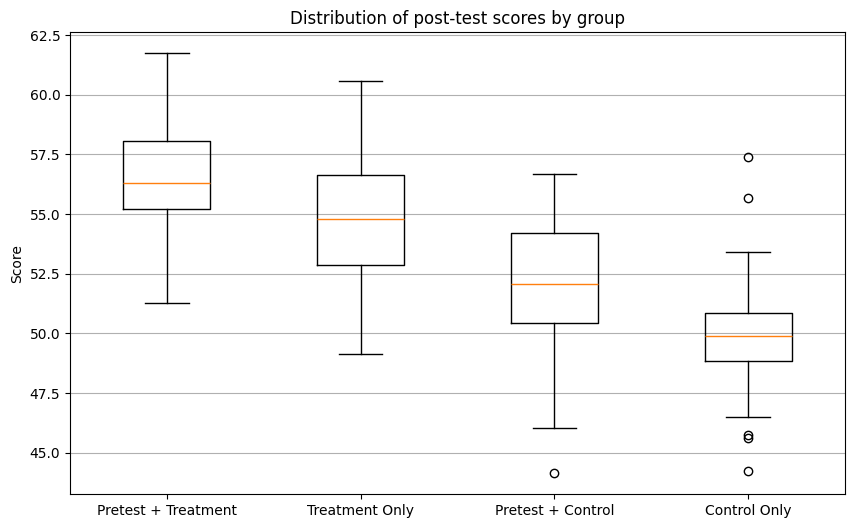

In [6]:
# Visualization
plt.figure(figsize=(10, 6))
plt.boxplot([
    data[data['Group'] == 'Pretest + Treatment']['Posttest'],
    data[data['Group'] == 'Treatment Only']['Posttest'],
    data[data['Group'] == 'Pretest + Control']['Posttest'],
    data[data['Group'] == 'Control Only']['Posttest']
], tick_labels=['Pretest + Treatment', 'Treatment Only', 'Pretest + Control', 'Control Only'])
plt.title('Distribution of post-test scores by group')
plt.ylabel('Score')
plt.grid(axis='y')
plt.show()



This boxplot shows the distribution of post-test scores for the four experimental groups.
- Pretest + Treatment: shows the highest median and relatively narrow dispersion.
- Treatment Only: the median is slightly lower than "Pretest + Treatment", with a wider dispersion.
- Pretest + Control: the median is lower than the treatment groups but higher than the control.
- Control Only: has the lowest median and widest dispersion, with some outliers present.

Conclusion:
The graph shows clear differences in post-test scores between groups, supporting the results of the ANOVA of significant variance.

### Post-hoc

We perform post-hoc comparisons and comparisons of means to identify which specific groups differ significantly after finding overall significance with ANOVA.

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Let's create an object for Tukey's post-hoc test
posthoc = pairwise_tukeyhsd(
    data['Posttest'],  # Post-test score values
    data['Group'],     # Experimental groups
    alpha=0.05         # Significance level (5%)
)

# Let's print the results
print(posthoc)




             Multiple Comparison of Means - Tukey HSD, FWER=0.05             
       group1              group2       meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------------------
       Control Only   Pretest + Control   2.0994 0.0227  0.2142 3.9846   True
       Control Only Pretest + Treatment   6.4963    0.0  4.6111 8.3815   True
       Control Only      Treatment Only   4.6973    0.0  2.8121 6.5825   True
  Pretest + Control Pretest + Treatment   4.3969    0.0  2.5117 6.2821   True
  Pretest + Control      Treatment Only   2.5979 0.0027  0.7127  4.483   True
Pretest + Treatment      Treatment Only   -1.799 0.0672 -3.6842 0.0861  False
-----------------------------------------------------------------------------


**Control Only** vs. **Pretest + Control**: The difference in means is 2.0994, with a p-value of 0.0227. Since the p-value is below 0.05, **the difference is statistically significant**.

**Control Only** vs. '*Pretest + Treatment**: The difference in means is 6.4963, with a p-value of 0.0. **This difference is statistically significant**.

**Control Only** vs. **Treatment Only**: The difference in means is 4.6973, with a p-value of 0.0. **This difference is statistically significant**.

**Pretest + Control** vs. **Pretest + Treatment**: The difference in means is 4.3969, with a p-value of 0.0. **This difference is statistically significan**t.

**Pretest + Control** vs. **Treatment Only**: The difference in means is 2.5979, with a p-value of 0.0027. **This difference is statistically significant**.

**Pretest + Treatment** vs. **Treatment Only**: The difference in means is -1.799, with a p-value of 0.0672. This p-value is greater than 0.05, so **the difference is not statistically significant**.

In conclusion, all group comparisons are statistically significant except for the comparison between Pretest + Treatment and Treatment Only.

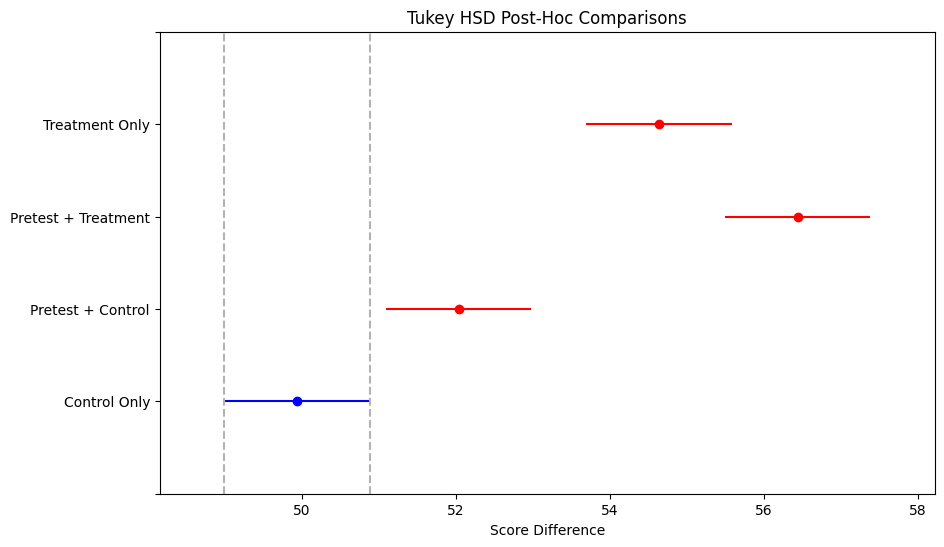

In [8]:
# We display the results in tabular format
posthoc.plot_simultaneous(comparison_name='Control Only', xlabel='Score Difference')
plt.title('Tukey HSD Post-Hoc Comparisons')
plt.show()


The graph only shows what we said previously.

### Difference between averages

In [9]:
#Comparison between groups to calculate accuracy of effects
mean_differences = data.groupby('Group')['Posttest'].mean()
print("Mean differences between groups:")
print(mean_differences)

Mean differences between groups:
Group
Control Only           49.939245
Pretest + Control      52.038654
Pretest + Treatment    56.435559
Treatment Only         54.636513
Name: Posttest, dtype: float64


The result of this code displays the mean post-test scores for each experimental group. These values provide an initial understanding of the performance differences between groups based on the treatment and/or pretest.

Interpretation of the result:
Groups with higher mean scores: If a group like "Pretest + Treatment" has a higher mean compared to others, it suggests that the treatment, combined with the pretest, had a positive effect.

Groups with lower mean scores: A group like "Control Only" with a lower mean may indicate the absence of treatment or pretest, reflecting the baseline performance of participants.

Comparisons between groups: Differences in means illustrate the effects of the treatment and pretest. For example:

A large difference between "Pretest + Treatment" and "Control Only" suggests a strong treatment effect.
Differences between "Pretest + Control" and "Control Only" reflect the isolated effect of the pretest.
In summary, these values serve as a preliminary step in quantifying and interpreting the impact of different interventions on the groups.

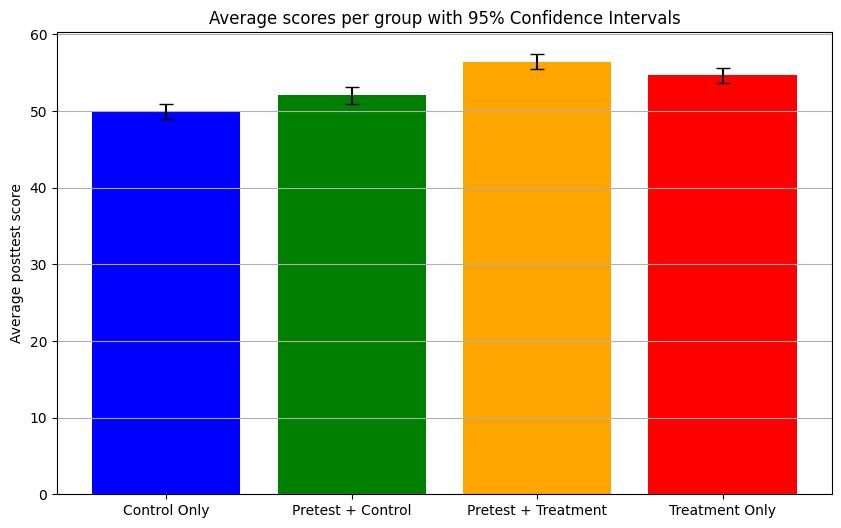

In [10]:
#1. Calculation of means and confidence intervals
group_means = data.groupby('Group')['Posttest'].mean()
group_std = data.groupby('Group')['Posttest'].std()
group_size = data.groupby('Group').size()

conf_intervals = 1.96 * (group_std / np.sqrt(group_size)) # Confidence Interval 95% 

# Graph of means with confidence intervals
plt.figure(figsize=(10, 6))
plt.bar(group_means.index, group_means.values, yerr=conf_intervals, capsize=5, color=['blue', 'green', 'orange', 'red'])
plt.ylabel('Average posttest score')
plt.title('Average scores per group with 95% Confidence Intervals')
plt.grid(axis='y')
plt.show()

The graph shows the post-test mean scores for each group (Control Only, Pretest + Control, Pretest + Treatment, Treatment Only), with error bars representing 95% confidence intervals. It is observed that the treatment groups (Pretest + Treatment and Treatment Only) have higher means than the control groups, indicating a clear treatment effect. The partial overlap of error bars between some groups suggests that not all differences may be statistically significant.

### Conclusions

This study aimed to investigate the effect of treatment on post-test scores across four experimental groups, following Solomon's experimental design.

**ANOVA Results**: The analysis revealed significant differences between the groups, as indicated by a high F-statistic and a very low p-value. This confirms that the treatment had a statistically significant effect on post-test scores.

**Mean Differences**: The average post-test scores showed that the groups receiving the treatment (with or without a pre-test) had consistently higher scores than the control groups, indicating the positive impact of the treatment.

**Visualization of Averages**: The bar chart with 95% confidence intervals confirmed that the treatment groups outperformed the control groups. However, the overlapping confidence intervals for some groups suggest the need for further investigation of specific group comparisons.

**Post-hoc Tukey HSD Test**: The Tukey HSD plot demonstrated that the differences between the treatment groups and the control groups were statistically significant, as their confidence intervals did not overlap. These results provide strong evidence that the treatment had a meaningful impact on outcomes.

#### **Overall Conclusion**:
The study supports the hypothesis that the treatment significantly improves post-test performance. The results are robust across different statistical methods (ANOVA and Tukey's test). Additionally, the Solomon design effectively controlled for pre-test effects, showing that the pre-test did not confound the treatment's impact. This confirms the reliability of the observed treatment effects.